# Análisis de las nubes de puntos

In [4]:
import open3d as o3d
import cv2
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from collections import defaultdict
from scipy.stats import gaussian_kde

## Explicación breve

Entre las imágenes de troncos proporcionadas, se encuentran varias nubes de puntos. Cada tronco tiene nubes de puntos de sus 4 rotaciones, 5 por cada rotación, aunque estas parecen idénticas entre sí.

Para poder trabajar correctamente con algoritmos que permitan usar estas nubes para analizar los troncos, sería ideal poder integrar estas 4 rotaciones en una sola imagen.

## Fusionar frames de las rotaciones

En primer lugar, para tener en cuenta posibles variaciones en la información de cada frame, y para temer más información de cada rotación, se pueden fusionar los frames mediante registrado

In [5]:
def merge_clouds(pole_id, rotation):
    pole_dir = f'LiDAR/{pole_id}/3d/{rotation}'
    frames = os.listdir(pole_dir)
    frames = [path for path in frames if 'Frame' in path]
    
    pcd = o3d.io.read_point_cloud(os.path.join(pole_dir, frames[0]))
    for frame in frames[1:]:
        frame_pcd = o3d.io.read_point_cloud(os.path.join(pole_dir, frame))
        reg_p2p = o3d.pipelines.registration.registration_icp(
            pcd, 
            frame_pcd, 
            0.02, 
            estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            criteria=o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=30)
        )
        pcd.transform(reg_p2p.transformation)
        pcd.points.extend(np.asarray(frame_pcd.points))
        
    return pcd

In [7]:
pole_ids = [0,5,6,30,41]
rotations = [0,90,180,270]

for pole in pole_ids:
    for rotation in rotations:
        cloud = merge_clouds(pole, rotation)
        o3d.io.write_point_cloud(f'LiDAR/{pole}/3d/{rotation}/cloud_merged.pcd', cloud)

Una vez hecho esto, en `poles_dict` se puede almacenar, para cada tronco, sus rotaciones, y de esta manera prepararlo todo para analizar o registrar cada tronco

In [17]:
def cut_pole(pole_id, rotation, draw=False):
    pole_dir = f'LiDAR/{pole_id}/3d/{rotation}'
    pointcloud = o3d.io.read_point_cloud(os.path.join(pole_dir, 'cloud_merged.pcd'))
    pointcloud_as_array = np.asarray(pointcloud.points)
    
    X = 0
    Ymin = -0.83
    Z = -1.25
    Zmin = -1.5
    dist = 0.4
    
    final_pointcloud_array = []
    
    for point in pointcloud_as_array:
        if (sqrt((X - point[0])**2 + (Z - point[2])**2) < dist) and (point[1] > Ymin) and (point[2] > Zmin):
            final_pointcloud_array.append(point)
    
    final_pointcloud = o3d.geometry.PointCloud()
    final_pointcloud.points = o3d.utility.Vector3dVector(final_pointcloud_array)
    final_pointcloud.estimate_normals()
    
    if draw:
        o3d.visualization.draw_geometries([final_pointcloud])
    
    else:
        return final_pointcloud

In [38]:
pole_ids = [0,5,6,30,41]

poles_dict = {}

for pole in pole_ids:
    poles_dict[f'pole_{pole}'] = [cut_pole(pole,rotation,draw=False) for rotation in [0,90,180,270]]

In [68]:
cut_pole(41, 180, True)

## Normalize PCD coordinates

To ease further analysis, it is a good idea to normalize the PCD coordinates to the range (-1, 1)

In [39]:
def normalize_pcd(pcd, draw=False):
    pcd_np = np.asarray(pcd.points)
    pcd_norm = 2 * ((pcd_np - np.min(pcd_np, axis=0)) / (np.max(pcd_np, axis=0) - np.min(pcd_np, axis=0))) - 1
    
    final_pointcloud = o3d.geometry.PointCloud()
    final_pointcloud.points = o3d.utility.Vector3dVector(pcd_norm)
    final_pointcloud.estimate_normals()
    
    if draw:
        o3d.visualization.draw_geometries([final_pointcloud])
    
    else:
        return final_pointcloud    

In [40]:
pole_ids = [0,30,41,6,5] 

for pole_idx, pole_id in enumerate(pole_ids):
    for rotation_idx in range(4):
        cloud = normalize_pcd(poles_dict[f'pole_{pole_id}'][rotation_idx])
        o3d.io.write_point_cloud(f'LiDAR/{pole_id}/3d/{rotation_idx * 90}/cloud_norm.pcd', cloud)

Como primera opción, se puede coger cada sector de cada tronco, y analizar cuántos puntos hay en las distintas líneas verticales. Esto puede dar una idea de si los puntos están, por lo general, tendientes a salir hacia fuera (que parece ser característica de los buenos troncos), o más bien hacia dentro (que podría indicar podredumbre). Para ello, se pueden voxelizar los troncos.

In [41]:
pole_ids = [0,5,6,30,41]

poles_dict = {}

for pole in pole_ids:
    poles_dict[f'pole_{pole}'] = [o3d.io.read_point_cloud(f'LiDAR/{pole}/3d/{rotation}/cloud_norm.pcd') for rotation in [0,90,180,270]]

## Voxelize

In [5]:
def voxelize(pole):
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pole, voxel_size=0.01)
    #o3d.visualization.draw_geometries([voxel_grid])
    return voxel_grid

In [6]:
voxel_dict = {}

for pole in poles_dict:
    voxel_dict[pole] = []
    for rotation in poles_dict[pole]:
        voxel_dict[pole].append(voxelize(rotation))

Con el tronco voxelizado, lo próximo que se puede hacer es analizar la densidad de puntos, bien en cada línea vertical, o bien en cada *slice* horizontal del tronco.

In [138]:
def slices_counter(pole):
    vertical_counts = defaultdict(int)
    horizontal_counts = defaultdict(int)
    
    for voxel in pole.get_voxels():
        x,y,z = voxel.grid_index
        vertical_counts[(x,z)] += 1
        horizontal_counts[y] += 1
        
    return {
        'vertical': list(vertical_counts.values()),
        'horizontal': list(horizontal_counts.values())
    }

In [139]:
counts_dict = {}

for pole in voxel_dict:
    counts_dict[pole] = []
    for rotation in voxel_dict[pole]:
        counts_dict[pole].append(slices_counter(rotation))

Y con estos valores generados, ya se pueden visualizar las distribuciones de puntos para cada tronco:

In [152]:
def visualize_distributions(counts):
    fig_vert, axes_vert = plt.subplots(5,4,figsize=(30,16))
    fig_hori, axes_hori = plt.subplots(5,4,figsize=(30,16))
    
    pole_ids = [0,30,41,6,5] 
    
    for pole_idx, pole_id in enumerate(pole_ids):
        for rotation_idx in range(4):
            axes_vert[pole_idx, rotation_idx].hist(counts[f'pole_{pole_id}'][rotation_idx]['vertical'], bins=20)
            axes_hori[pole_idx, rotation_idx].hist(counts[f'pole_{pole_id}'][rotation_idx]['horizontal'], bins=20)
            axes_vert[pole_idx, rotation_idx].set_xlim([0, 125])
            axes_vert[pole_idx, rotation_idx].set_ylim([0, 200])
            axes_hori[pole_idx, rotation_idx].set_xlim([0, 120])
            axes_hori[pole_idx, rotation_idx].set_ylim([0, 50])
            pole_id_crop = pole_id if pole_id != 0 else 'Ny'
            
    fig_vert.suptitle('Vertical slices distribution')
    fig_hori.suptitle('Horizontal slices distribution')
    
    [axes_vert[0,i].set_title(f'{i*90} degrees') for i in range(4)]
    [axes_hori[0,i].set_title(f'{i*90} degrees') for i in range(4)]
    
    [axes_vert[i,0].set_ylabel(f'Pole {pole}', labelpad=50, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]
    [axes_hori[i,0].set_ylabel(f'Pole {pole}', labelpad=50, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]
        
    fig_vert.savefig('slices_distribution_vertical.jpg')
    fig_hori.savefig('slices_distribution_horizontal.jpg')    

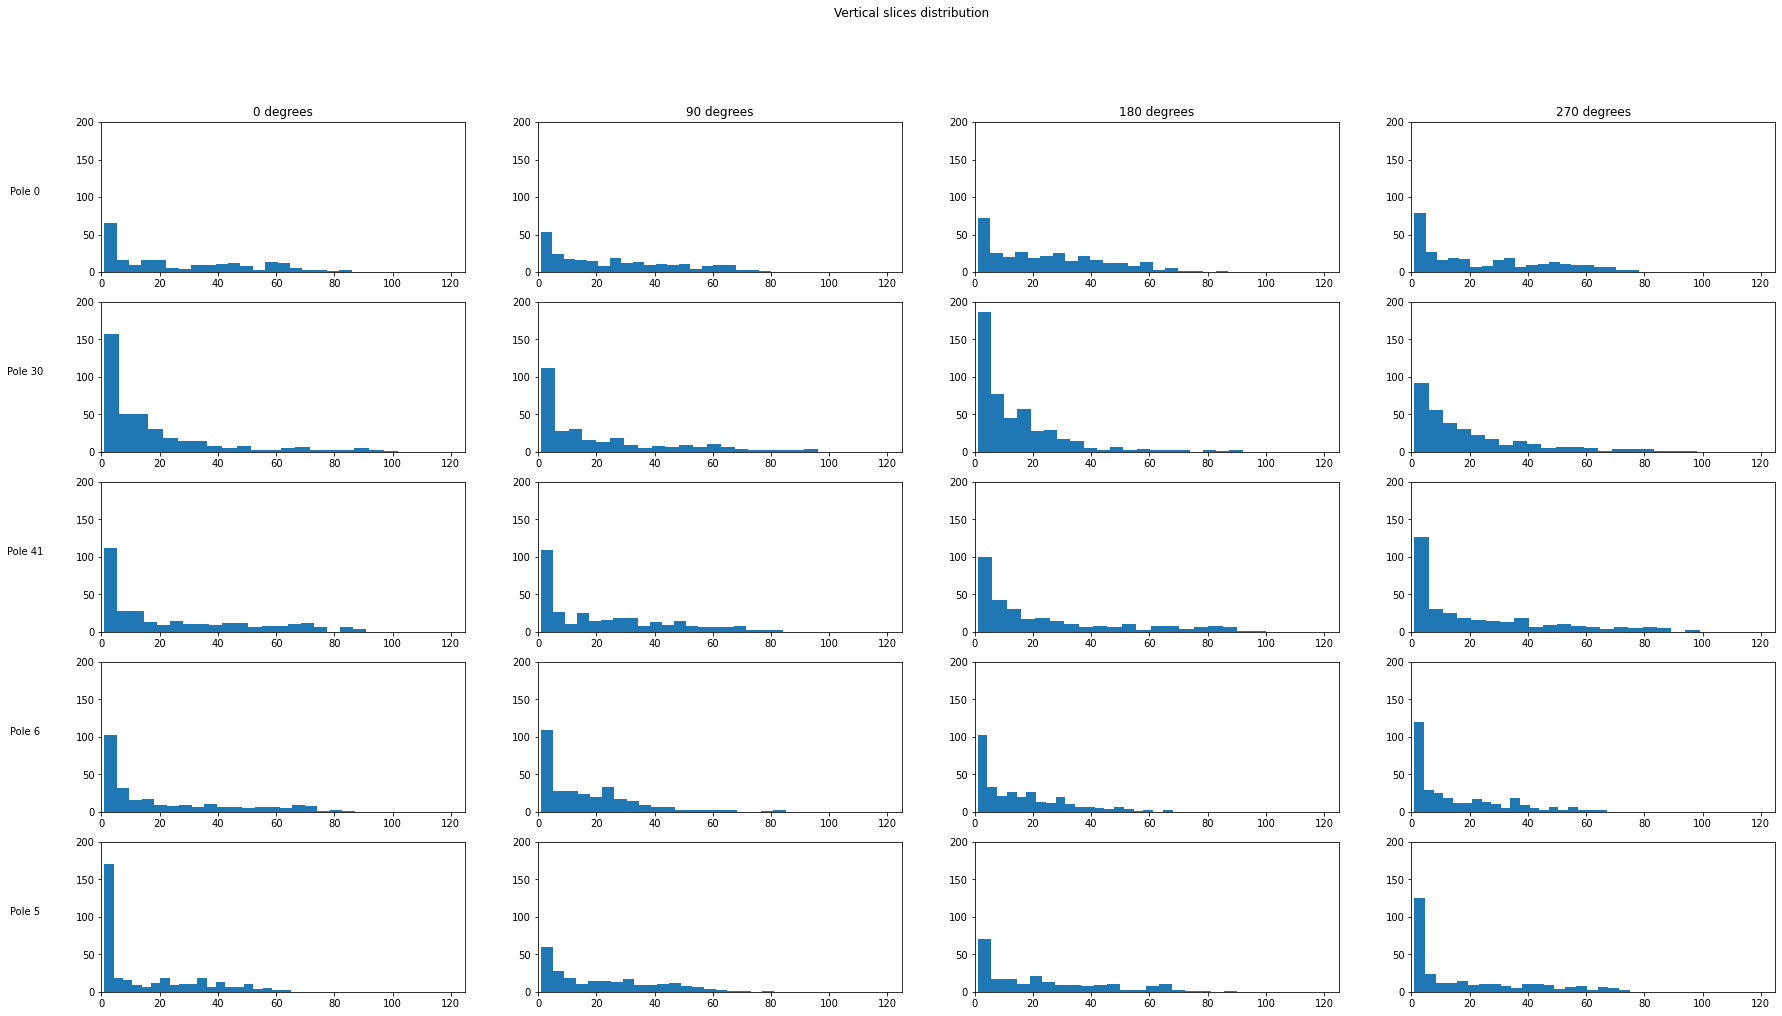

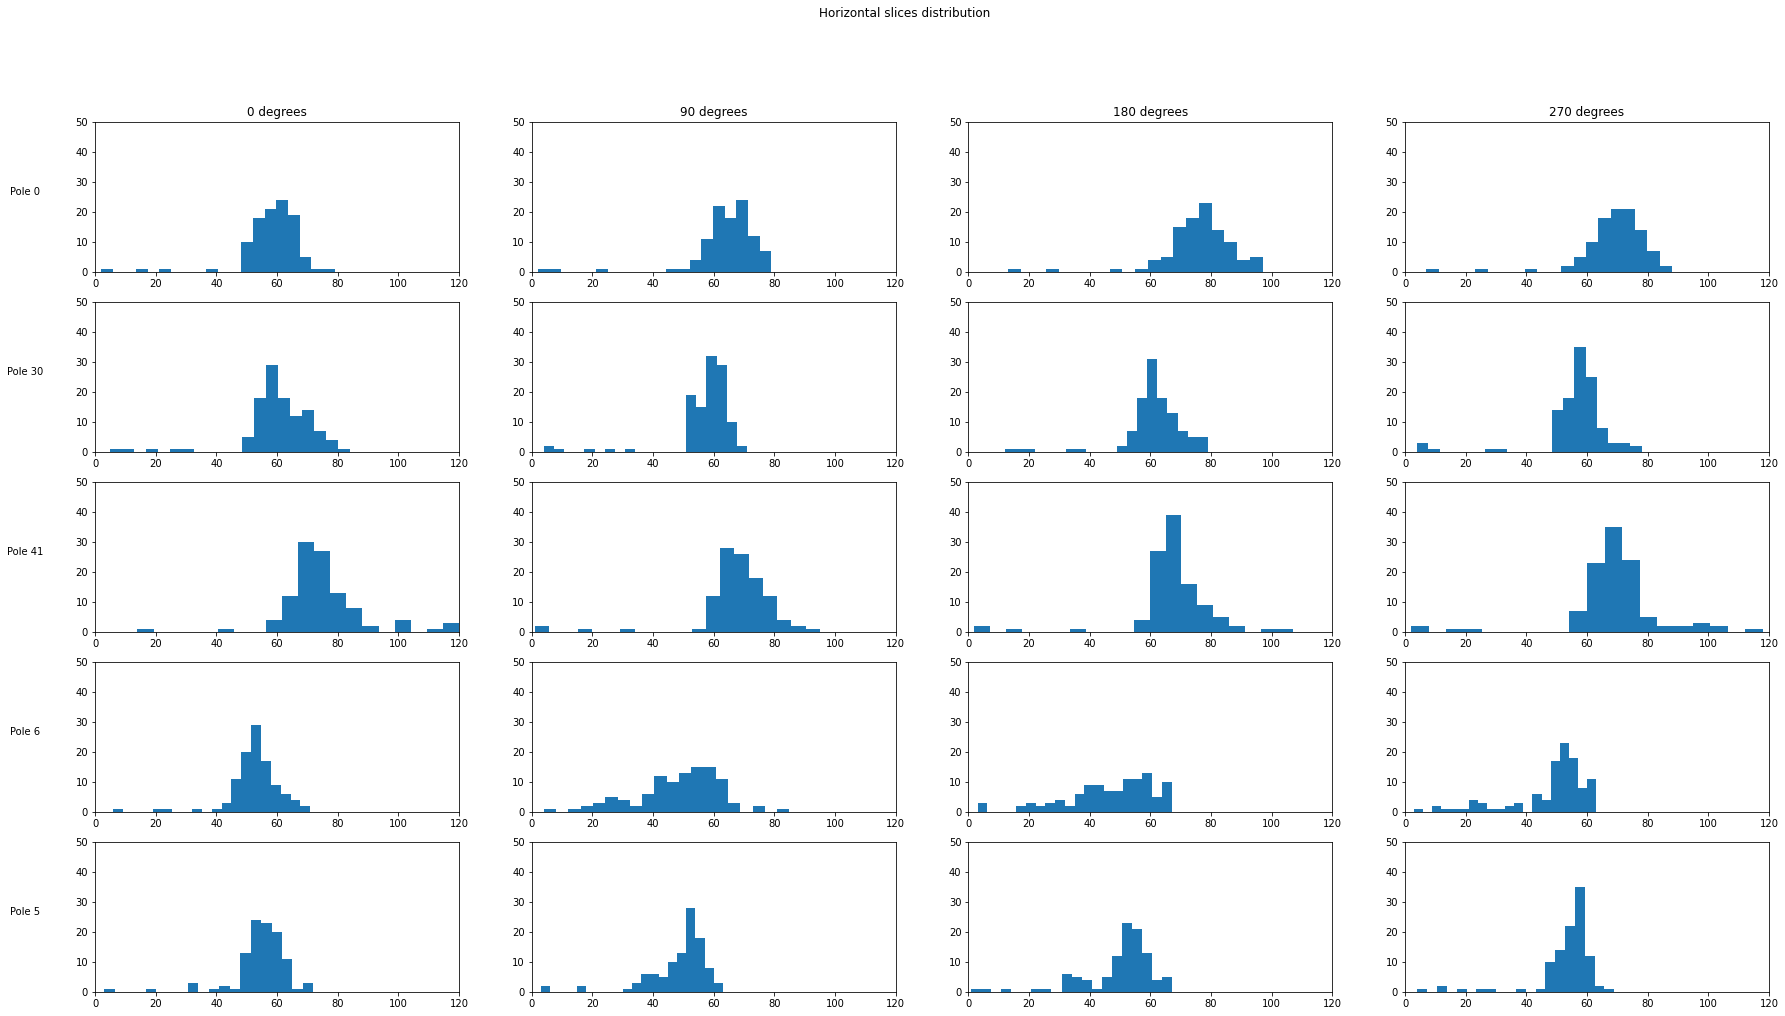

In [153]:
visualize_distributions(counts_dict)

## Otras opciones

### Scatter plot de las nubes de puntos (sin voxel)

Como se puede perder mucha información al voxelizar, una mejor opción es sacar scatter-plots de las posiciones X, Y y Z de los puntos. Al ser los peores troncos más irregulares, se espera que en estos haya más dispersión

In [42]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [59]:
axes_dict = {'X':0, 'Y':1, 'Z':2}
limits = {'XY': ((-1, 1),(-1, 1)), 'XZ': ((-1, 1),(-1, 1)), 'ZY': ((-1, 1),(-1, 1))}

def pole_scatter_plot(coord_axes, poles):
    fig = plt.figure(figsize=(25,16))
    gs = plt.GridSpec(5,4)
    pole_ids = [0,30,41,6,5]
    pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']
    derivatives_dict = {}    
    
    for pole_idx, pole_id in enumerate(pole_ids):
        for rotation_idx in range(4):
            pole_points = np.asarray(poles[f'pole_{pole_id}'][rotation_idx].points)
            points_first_axis = pole_points[:,axes_dict[coord_axes[0]]]
            points_second_axis = pole_points[:,axes_dict[coord_axes[1]]]
            jp = sns.jointplot(x=points_first_axis, y=points_second_axis, s=0.1, xlim=limits[coord_axes][0], ylim=limits[coord_axes][1], marginal_kws=dict(bins=20))
            mg = SeabornFig2Grid(jp, fig, gs[pole_idx, rotation_idx])
            
            # Get histogram derivatives, and compute max and min to estimate pole status
            x_marginal_values = [patch._height for patch in jp.ax_marg_x.patches]
            y_marginal_values = [patch._width for patch in jp.ax_marg_y.patches]
            
            x_idxs = np.nonzero(x_marginal_values)[0][[0,-1]]
            y_idxs = np.nonzero(y_marginal_values)[0][[0,-1]]
            
            x_marginal_values = x_marginal_values[x_idxs[0]:x_idxs[1]]
            y_marginal_values = y_marginal_values[y_idxs[0]:y_idxs[1]]
            
            dx_trimmed = np.diff(x_marginal_values)[1:-1]
            dy_trimmed = np.diff(y_marginal_values)[1:-1]
            
            max_dx, max_dy = np.max(np.abs(dx_trimmed)), np.max(np.abs(dy_trimmed))
            
            derivatives_dict[f'pole_{pole_id}_rotation_{rotation_idx * 90}'] = {
                'max DX': max_dx,
                'max DY': max_dy,
            }

    fig.suptitle(f'{coord_axes[0]}{coord_axes[1]} axes scatter plot')
    
    #[axes[0,i].set_title(f'{i*90} degrees') for i in range(4)]
    
    get_y_label_string = lambda i: (
        f'Pole {pole_ids[i]}\n'
        f'Status: {pole_status[i]}\n'
        f'Max X deviation: {np.max(pole_x_stdevs[i]):.2f}\n'
        f'Max Y deviation: {np.max(pole_y_stdevs[i]):.2f}\n'
        f'Max Z deviation: {np.max(pole_z_stdevs[i]):.2f}\n'
    )
    
    #[axes[i,0].set_ylabel(get_y_label_string(i), labelpad=60, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]
    plt.savefig(f'{coord_axes}_scatter.jpg')
    
    return derivatives_dict

{'pole_0_rotation_0': {'max DX': 722, 'max DY': 48},
 'pole_0_rotation_90': {'max DX': 409, 'max DY': 109},
 'pole_0_rotation_180': {'max DX': 713, 'max DY': 166},
 'pole_0_rotation_270': {'max DX': 634, 'max DY': 147},
 'pole_30_rotation_0': {'max DX': 619, 'max DY': 109},
 'pole_30_rotation_90': {'max DX': 791, 'max DY': 71},
 'pole_30_rotation_180': {'max DX': 548, 'max DY': 96},
 'pole_30_rotation_270': {'max DX': 634, 'max DY': 78},
 'pole_41_rotation_0': {'max DX': 492, 'max DY': 170},
 'pole_41_rotation_90': {'max DX': 768, 'max DY': 125},
 'pole_41_rotation_180': {'max DX': 818, 'max DY': 172},
 'pole_41_rotation_270': {'max DX': 765, 'max DY': 136},
 'pole_6_rotation_0': {'max DX': 385, 'max DY': 159},
 'pole_6_rotation_90': {'max DX': 708, 'max DY': 458},
 'pole_6_rotation_180': {'max DX': 325, 'max DY': 336},
 'pole_6_rotation_270': {'max DX': 414, 'max DY': 432},
 'pole_5_rotation_0': {'max DX': 289, 'max DY': 175},
 'pole_5_rotation_90': {'max DX': 560, 'max DY': 250},
 'p

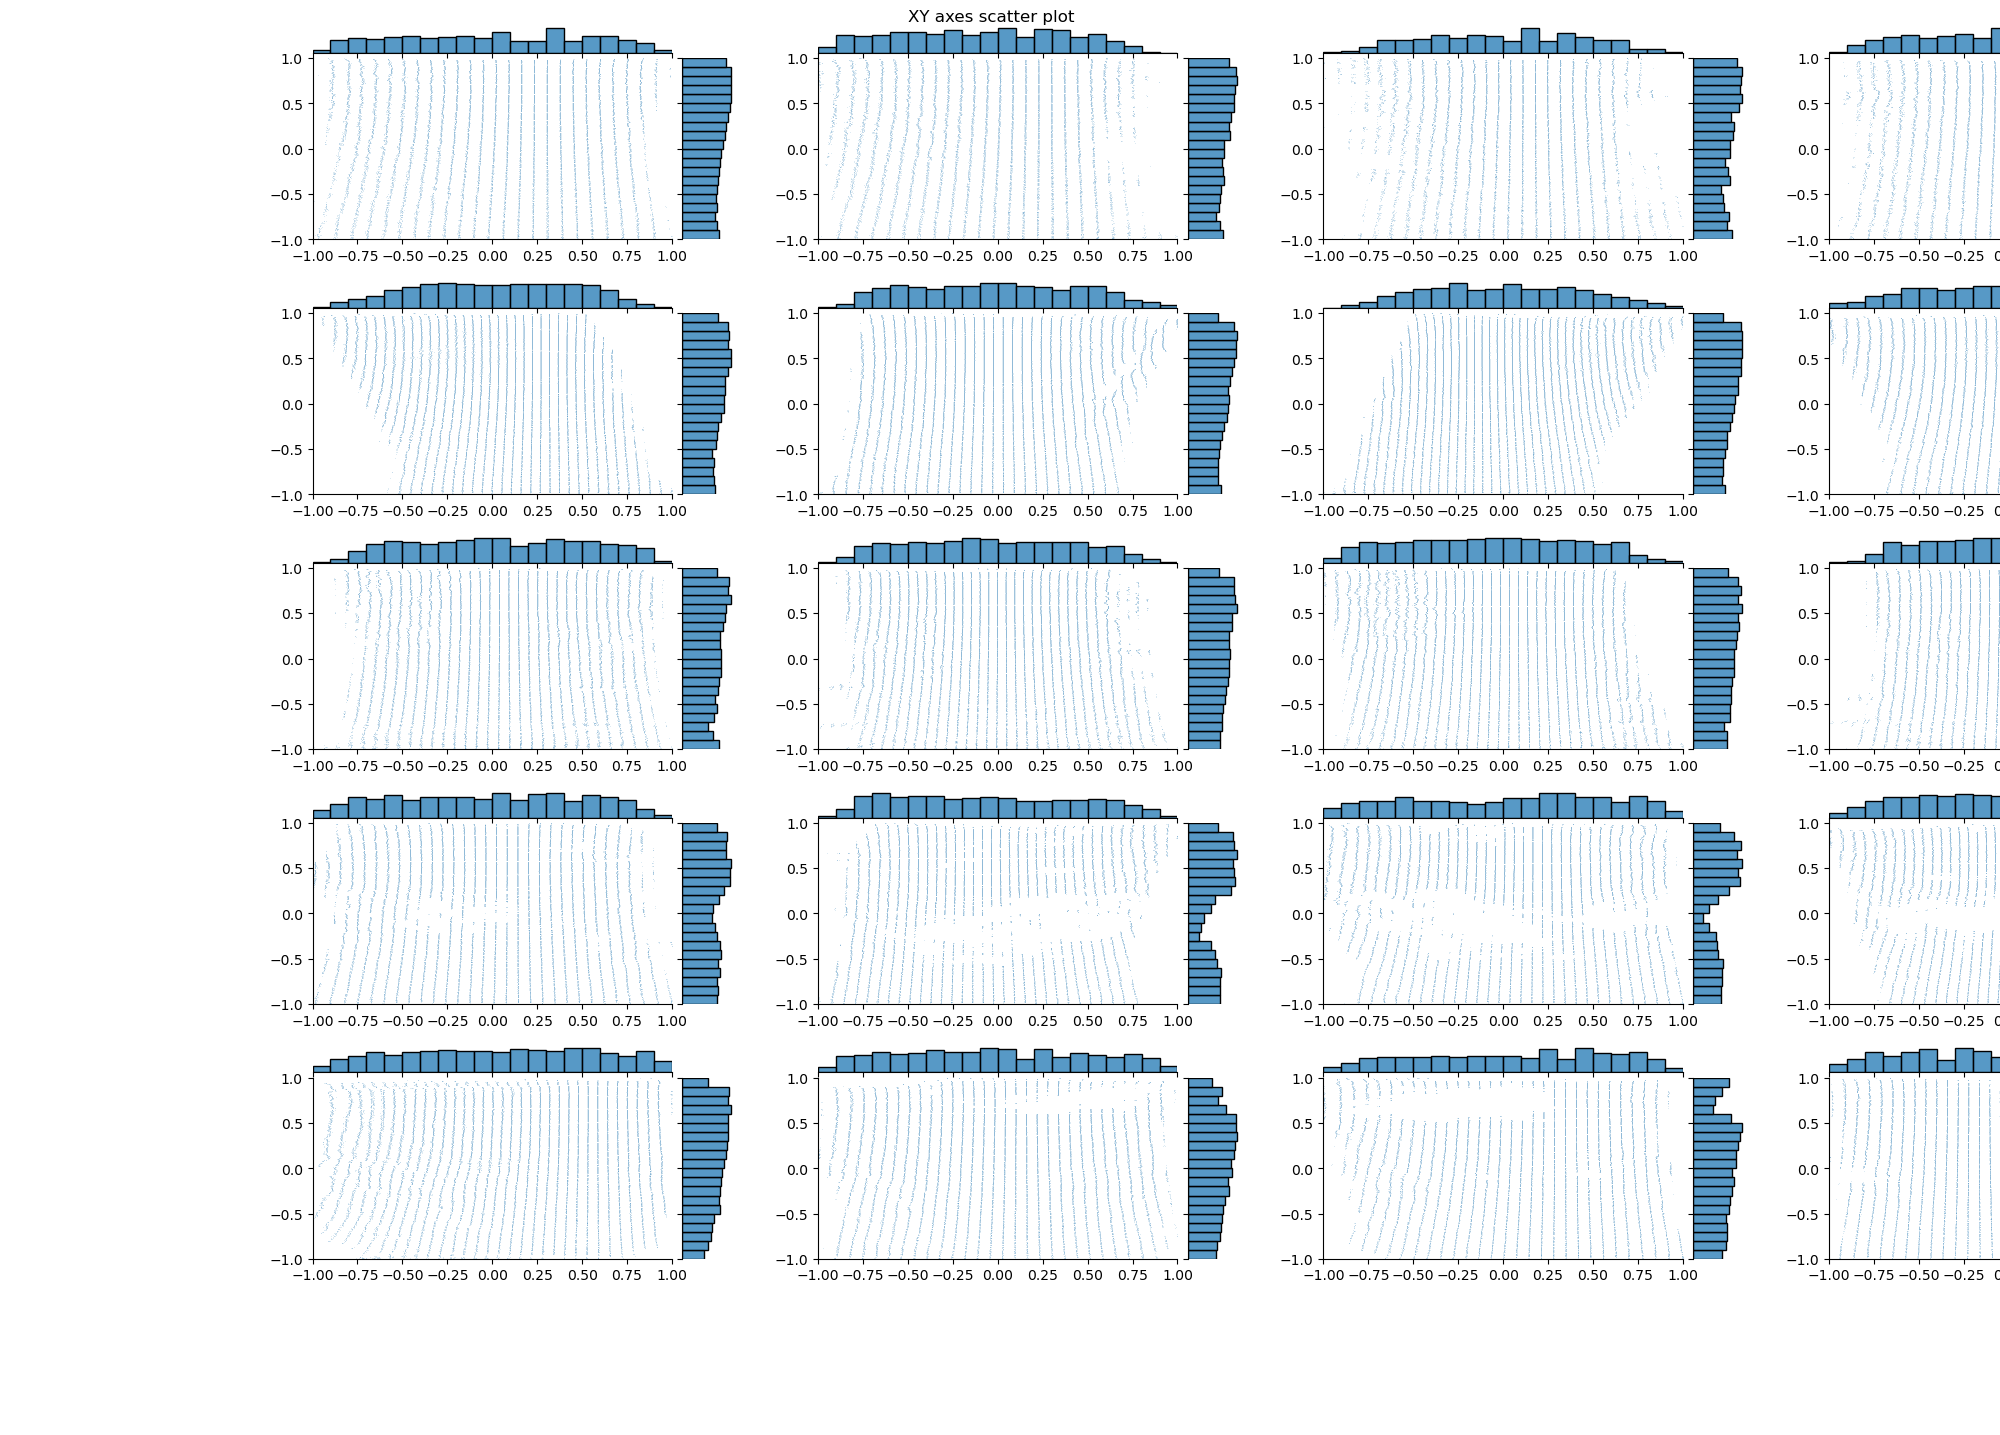

In [60]:
pole_scatter_plot('XY', poles_dict)

In [63]:
def pole_scatter_plot_with_depths(coord_axes, poles):
    fig = plt.figure(figsize=(25,16))
    gs = plt.GridSpec(5,4)
    pole_ids = [0,30,41,6,5]
    pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']
    derivatives_dict = {}
    remaining_axis = list(set('XYZ') - set(coord_axes))[0]
    
    for pole_idx, pole_id in enumerate(pole_ids):
        for rotation_idx in range(4):
            pole_points = np.asarray(poles[f'pole_{pole_id}'][rotation_idx].points)
            points_first_axis = pole_points[:,axes_dict[coord_axes[0]]]
            points_second_axis = pole_points[:,axes_dict[coord_axes[1]]]
            points_color_axis = pole_points[:,axes_dict[remaining_axis]]
            jp = sns.jointplot(x=points_first_axis, y=points_second_axis, s=0.1, xlim=limits[coord_axes][0], ylim=limits[coord_axes][1], hue=points_color_axis)
            mg = SeabornFig2Grid(jp, fig, gs[pole_idx, rotation_idx])

    fig.suptitle(f'{coord_axes[0]}{coord_axes[1]} axes scatter plot')
        
    get_y_label_string = lambda i: (
        f'Pole {pole_ids[i]}\n'
        f'Status: {pole_status[i]}\n'
    )
    
    plt.savefig(f'{coord_axes}_scatter_depths.jpg')
    
    return derivatives_dict

{}

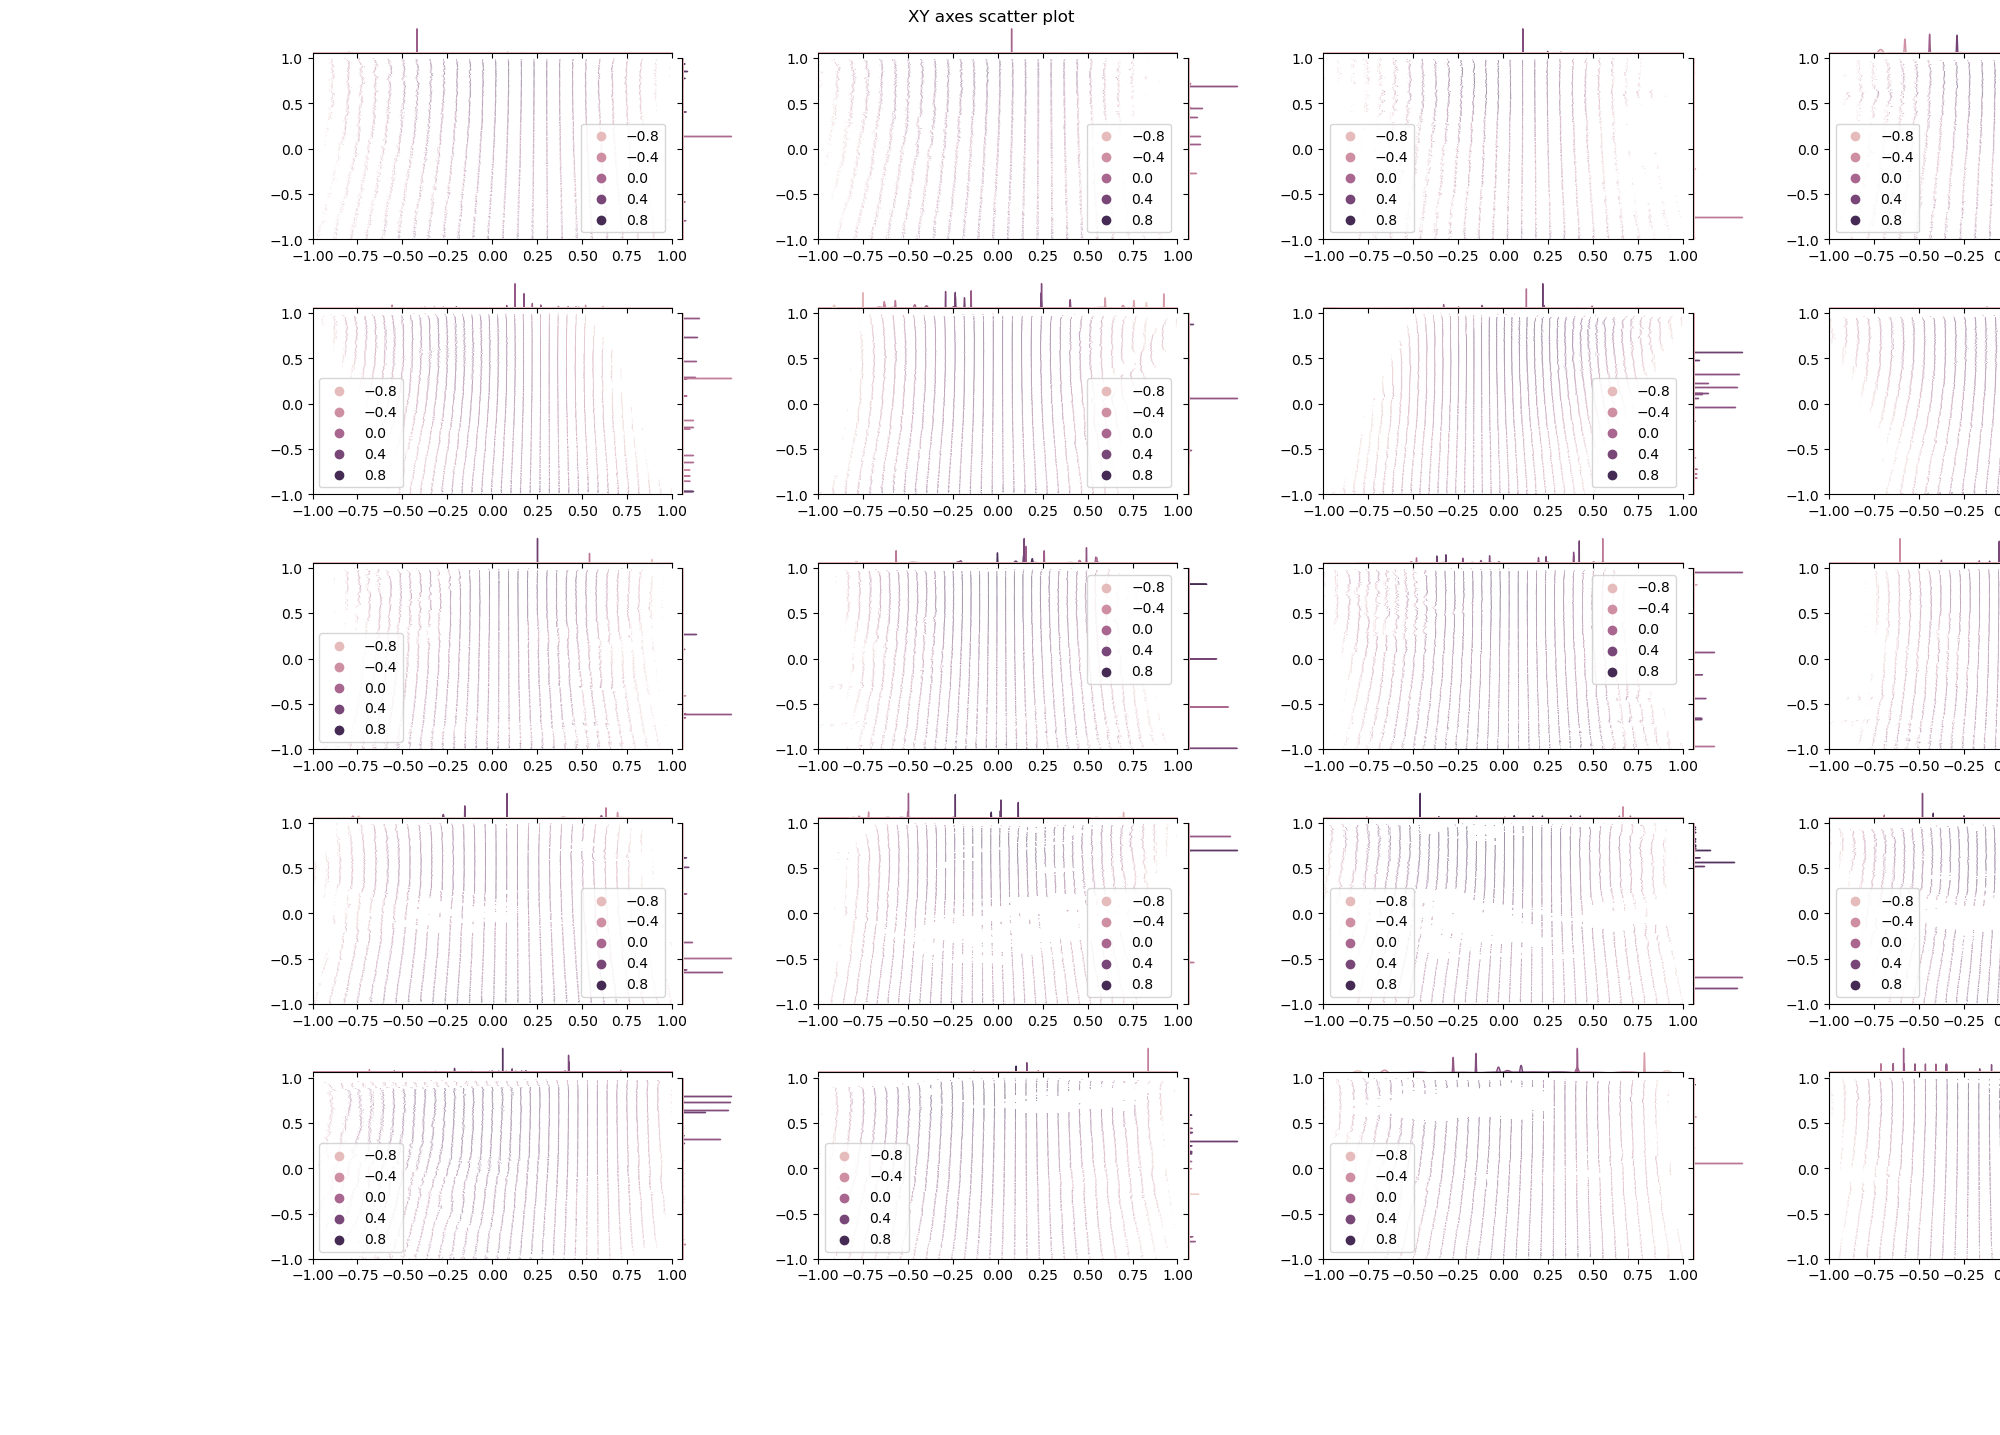

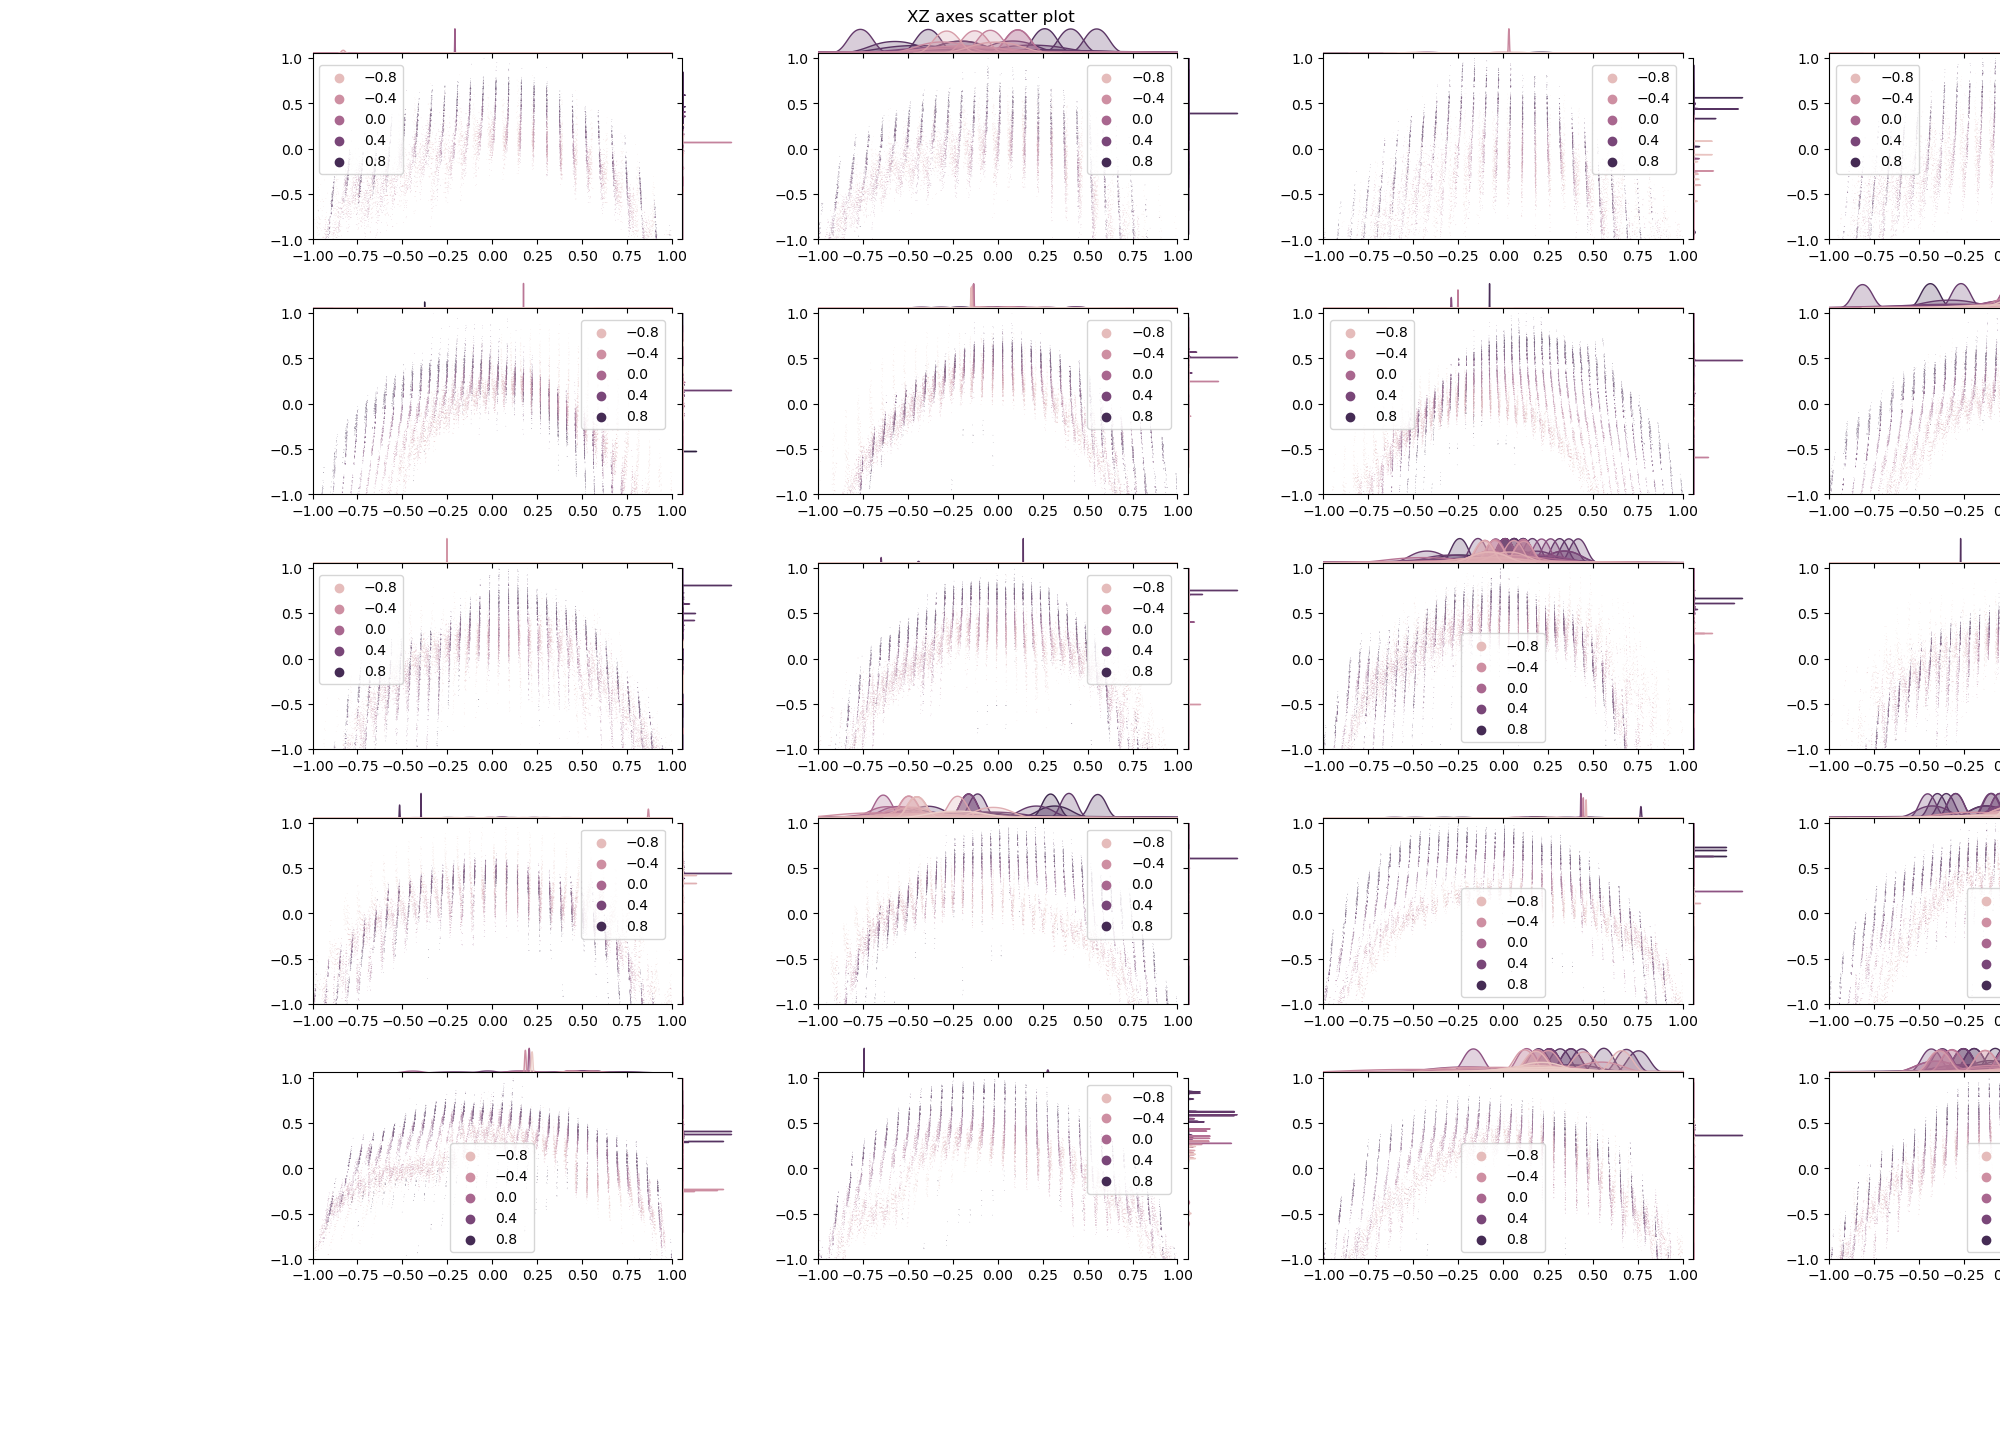

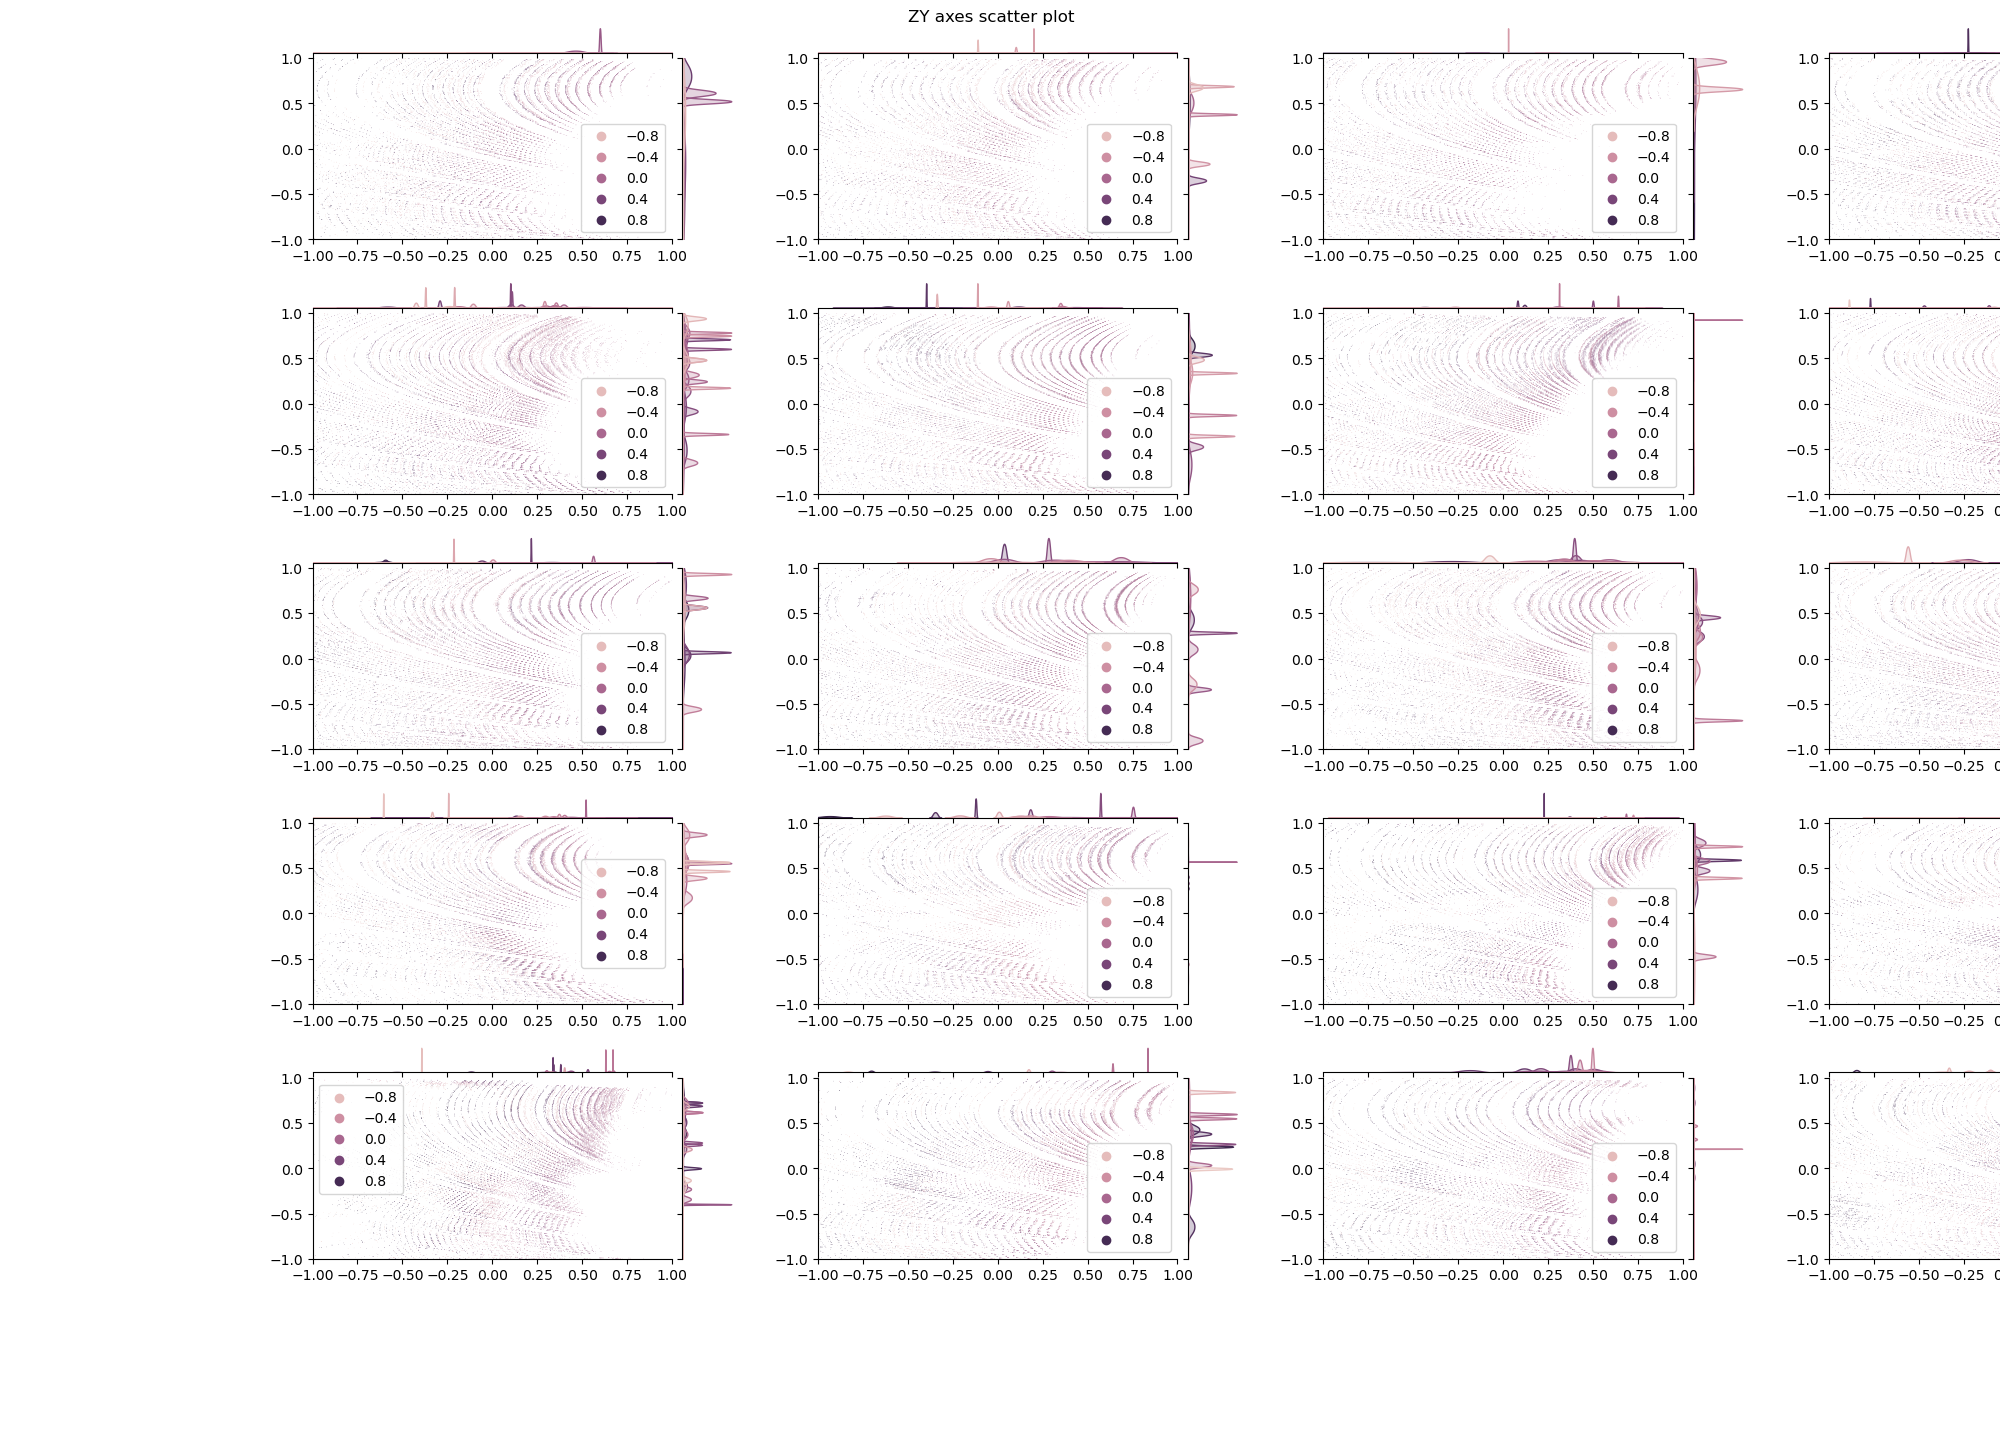

In [64]:
pole_scatter_plot_with_depths('XY', poles_dict)
pole_scatter_plot_with_depths('XZ', poles_dict)
pole_scatter_plot_with_depths('ZY', poles_dict)

## PCD distance

In addition to the scatter plots above, another good statistic for the condition of the poles can be the distances among the pole's rotations. Poles in worse condition will have very different rotations (due to their cracks), so this distance can give further insight

In [8]:
def visualize_distances(counts):
    fig, axes = plt.subplots(5, 6, figsize=(25,16))
    
    pole_ids = [0,30,41,6,5]
    pair_idx = 0
    
    # Get each pole and, for each pole, all pole pairs
    for pole_idx, pole_id in enumerate(pole_ids):
        pair_idx = 0
        dist_averages = []
        for rot_idx_1 in range(3):
            for rot_idx_2 in range(rot_idx_1+1, 4):
                distances = counts[f'pole_{pole_id}'][rot_idx_1].compute_point_cloud_distance(counts[f'pole_{pole_id}'][rot_idx_2])
                avg_distance = np.average(distances)
                dist_averages.append(avg_distance)
                axes[pole_idx,pair_idx].hist(distances, bins=1000, density=True)
                axes[pole_idx,pair_idx].set_xlim([0,1])
                axes[pole_idx,pair_idx].set_ylim([0,50])
                kde = gaussian_kde(distances)
                space = np.linspace(0,1,1000)
                axes[pole_idx,pair_idx].plot(space, kde(space))
                pair_idx += 1
        print(f'----------------------\nAverage of average distances for pole {pole_id}: {np.average(dist_averages):.4f} +- {np.std(dist_averages):.4f}\n----------------------')
            
    fig.suptitle('Pole rotations distance distribution')
    
    pair_idx = 0
    for rot_idx_1 in range(3):
            for rot_idx_2 in range(rot_idx_1+1, 4):
                axes[0,pair_idx].set_title(f'({rot_idx_1 * 90}º),({rot_idx_2 * 90}º) degrees')
                pair_idx += 1
        
    [axes[i,0].set_ylabel(f'Pole {pole}', labelpad=50, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]
        
    fig.savefig('pole_rotations_distances.jpg')
    

----------------------
Average of average distances for pole 0: 0.0417 +- 0.0042
----------------------
----------------------
Average of average distances for pole 30: 0.0660 +- 0.0229
----------------------
----------------------
Average of average distances for pole 41: 0.0434 +- 0.0060
----------------------
----------------------
Average of average distances for pole 6: 0.0600 +- 0.0093
----------------------
----------------------
Average of average distances for pole 5: 0.0478 +- 0.0074
----------------------


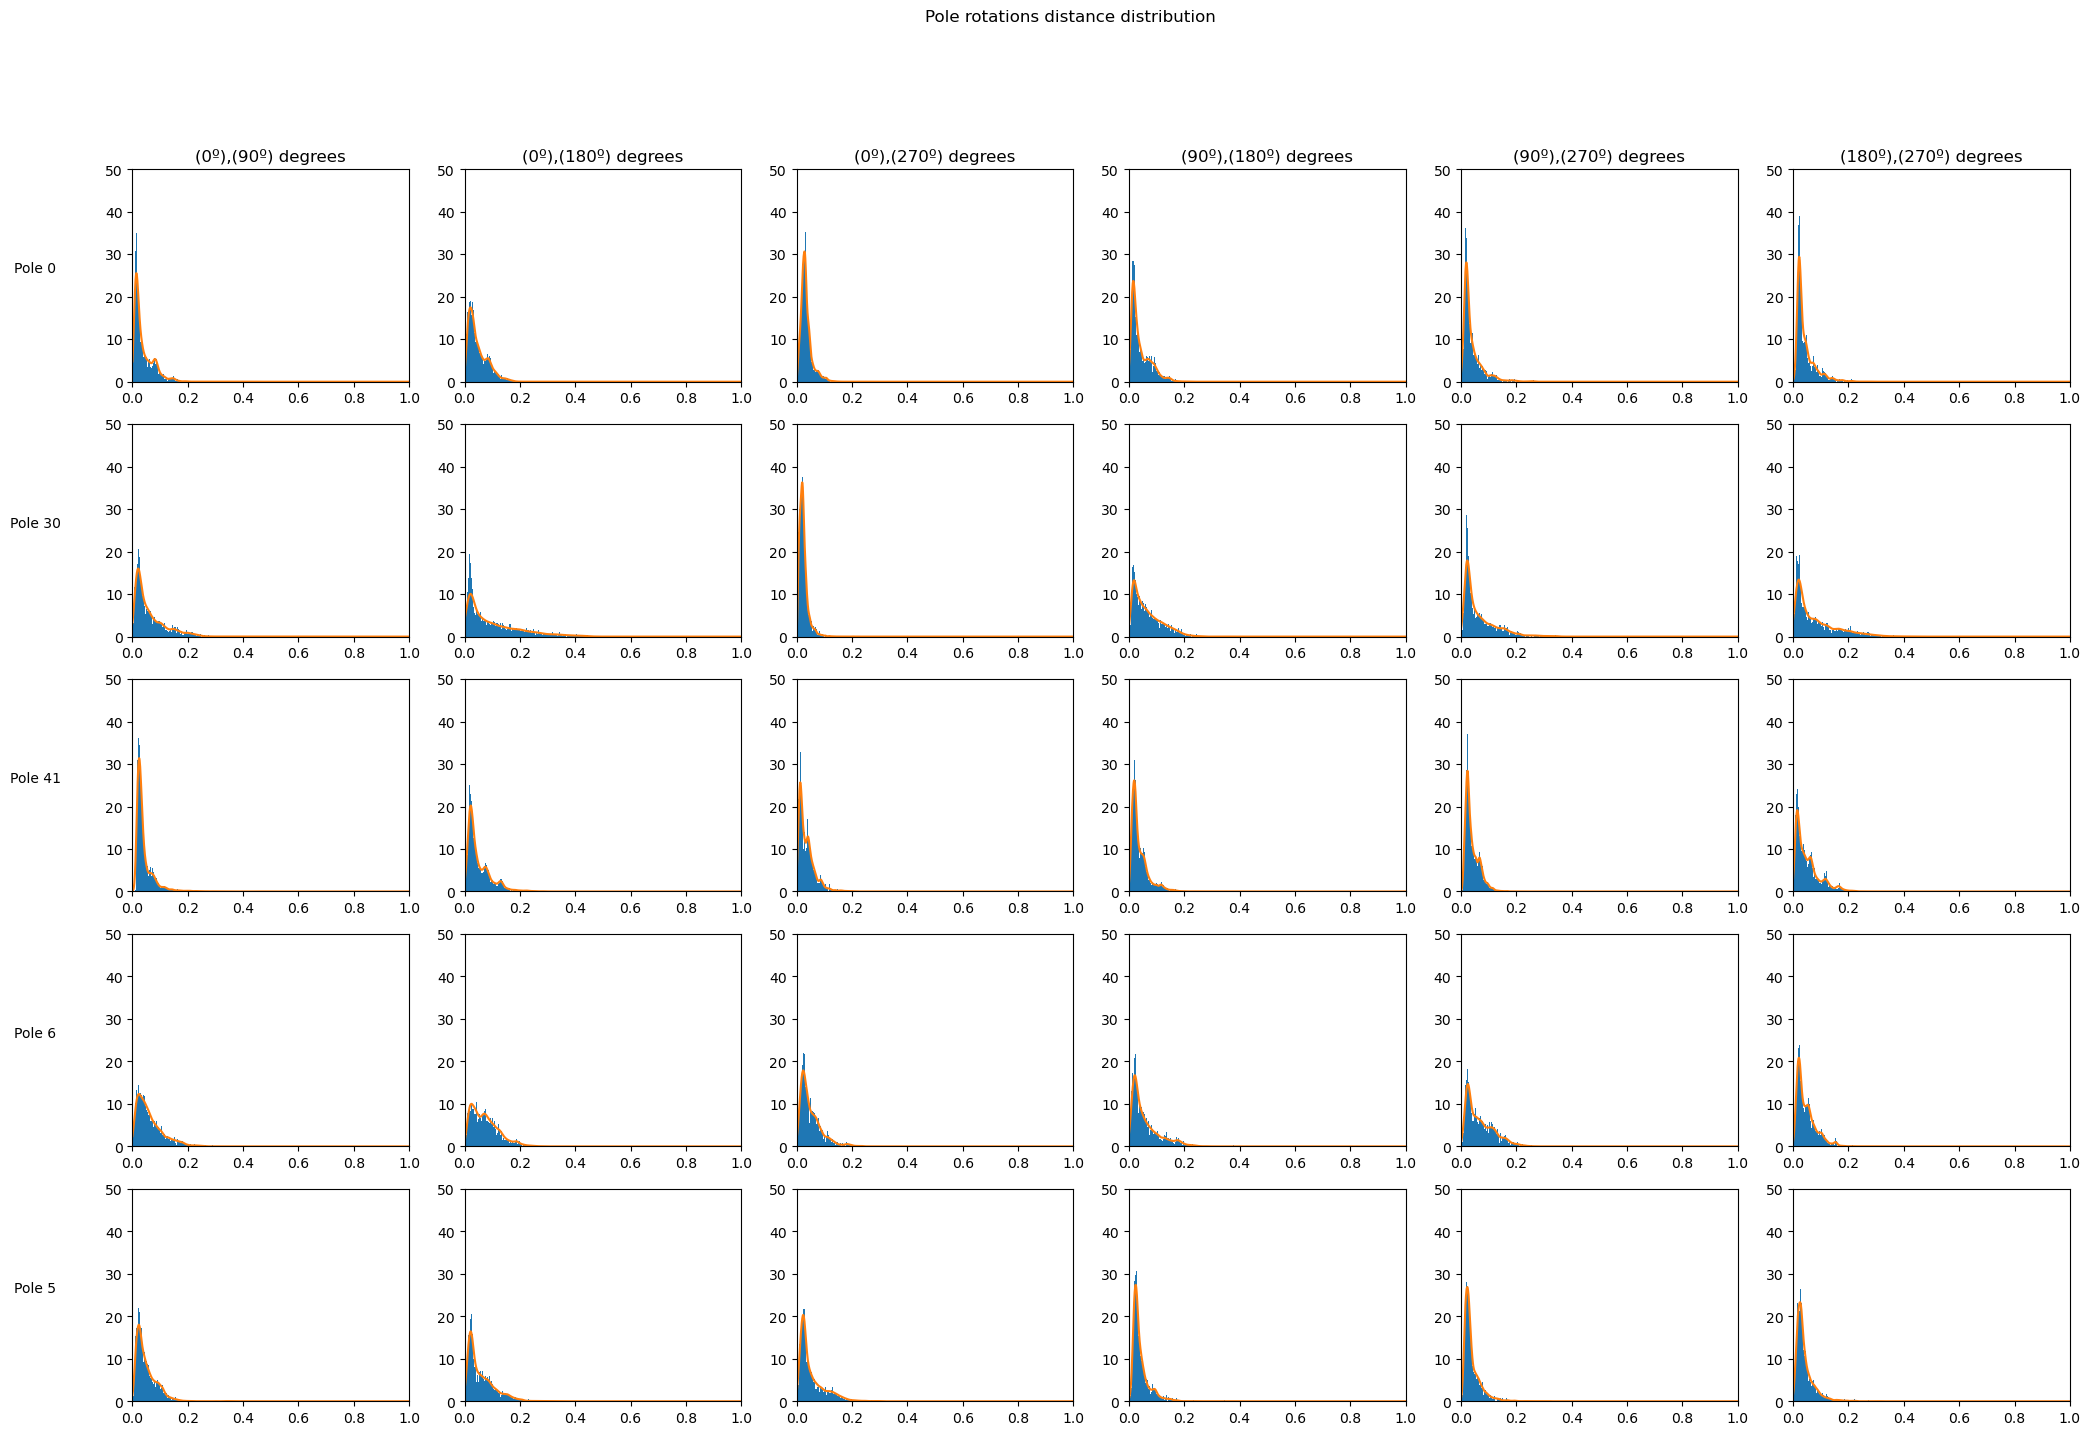

In [9]:
visualize_distances(poles_dict)

### Registrar troncos

In [8]:
def initialize_alignments(poles):

    poles_copy = copy.deepcopy(poles)

    cloud_0 = poles_copy[0]
    cloud_90 = poles_copy[1]
    cloud_90 = cloud_90.rotate(cloud_90.get_rotation_matrix_from_xyz((0, np.pi / 2, 0))).translate((0.1,0,-0.1))
    cloud_180 = poles_copy[2]
    cloud_180 = cloud_180.rotate(cloud_180.get_rotation_matrix_from_xyz((0, np.pi, 0))).translate((0,0,-0.2))
    cloud_270 = poles_copy[3]
    cloud_270 = cloud_270.rotate(cloud_270.get_rotation_matrix_from_xyz((0, 3 * np.pi / 2, 0))).translate((-0.1,0,-0.1))

    final_pointcloud = o3d.geometry.PointCloud()
    final_pointcloud.points = o3d.utility.Vector3dVector(np.concatenate([
        np.asarray(cloud_0.points), 
        np.asarray(cloud_90.points), 
        np.asarray(cloud_180.points), 
        np.asarray(cloud_270.points)
    ]))
    
    o3d.visualization.draw_geometries([final_pointcloud])
    return [cloud_0, cloud_90, cloud_180, cloud_270]

In [9]:
transformed_poles_dict = {}

for pole in pole_ids:
    transformed_poles_dict[f'pole_{pole}'] = initialize_alignments(poles_dict[f'pole_{pole}'])

KeyboardInterrupt: 

#### Pruebas con IPC registration

In [ ]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])
    
source = transformed_poles_dict['pole_5'][2]
target = transformed_poles_dict['pole_5'][1]
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, 
    target, 
    0.02, 
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    criteria=o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=30)
)
draw_registration_result(source, target, reg_p2p.transformation)

#### Pruebas con Multiway Registration

In [45]:
def pairwise_registration(source, target):
    print("Apply point-to-plane ICP")
    icp_coarse = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_coarse, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    icp_fine = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_fine,
        icp_coarse.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    transformation_icp = icp_fine.transformation
    information_icp = o3d.pipelines.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp


def full_registration(pcds, max_correspondence_distance_coarse,
                      max_correspondence_distance_fine):
    pose_graph = o3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in range(n_pcds):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], pcds[target_id])
            print("Build o3d.pipelines.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    o3d.pipelines.registration.PoseGraphNode(
                        np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    return pose_graph

In [49]:
print("Full registration ...")
pole_0 = transformed_poles_dict['pole_0']
max_correspondence_distance_coarse = 0.02 * 15
max_correspondence_distance_fine = 0.02 * 1.5

with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    pose_graph = full_registration(pole_0,
                                   max_correspondence_distance_coarse,
                                   max_correspondence_distance_fine)

Full registration ...
Apply point-to-plane ICP
[Open3D DEBUG] ICP Iteration #0: Fitness 1.0000, RMSE 0.1134
[Open3D DEBUG] Residual : 3.92e-03 (# of elements : 3335)
[Open3D DEBUG] ICP Iteration #1: Fitness 0.9988, RMSE 0.2487
[Open3D DEBUG] Residual : 5.13e-02 (# of elements : 3331)
[Open3D DEBUG] ICP Iteration #2: Fitness 1.0000, RMSE 0.0329
[Open3D DEBUG] Residual : 7.90e-04 (# of elements : 3335)
[Open3D DEBUG] ICP Iteration #3: Fitness 1.0000, RMSE 0.1070
[Open3D DEBUG] Residual : 7.95e-03 (# of elements : 3335)
[Open3D DEBUG] ICP Iteration #4: Fitness 1.0000, RMSE 0.0461
[Open3D DEBUG] Residual : 1.29e-03 (# of elements : 3335)
[Open3D DEBUG] ICP Iteration #5: Fitness 1.0000, RMSE 0.0271
[Open3D DEBUG] Residual : 5.31e-04 (# of elements : 3335)
[Open3D DEBUG] ICP Iteration #6: Fitness 1.0000, RMSE 0.0190
[Open3D DEBUG] Residual : 2.17e-04 (# of elements : 3335)
[Open3D DEBUG] ICP Iteration #7: Fitness 1.0000, RMSE 0.0124
[Open3D DEBUG] Residual : 6.40e-05 (# of elements : 3335)
[

In [59]:
print("Optimizing PoseGraph ...")
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0)
optim = o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria()
optim.max_iteration = 1
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        pose_graph,
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        optim,
        option)

Optimizing PoseGraph ...
[Open3D DEBUG] Validating PoseGraph - finished.
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 4 nodes and 6 edges.
[Open3D DEBUG] Line process weight : 2.828700
[Open3D DEBUG] [Initial     ] residual : 2.613827e-01, lambda : 2.728784e-01
[Open3D DEBUG] [Iteration 00] residual : 2.584591e-01, valid edges : 3, time : 0.000 sec.
[Open3D DEBUG] [Iteration 01] residual : 2.584555e-01, valid edges : 3, time : 0.000 sec.
[Open3D DEBUG] Reached maximum number of iterations (1)
[Open3D DEBUG] [GlobalOptimizationLM] total time : 0.000 sec.
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 4 nodes and 6 edges.
[Open3D DEBUG] Line process weight : 2.828700
[Open3D DEBUG] [Initial     ] residual : 2.584555e-01, lambda : 2.726488e-01
[Open3D DEBUG] Delta.norm() < 1.000000e-06 * (x.norm() + 1.000000e-06)
[Open3D DEBUG] [GlobalOptimizationLM] total time : 0.000 sec.
[Open3D DEBUG] CompensateReferencePoseGraphNode : reference : 0


In [60]:
print("Transform points and display")
for point_id in range(len(pole_0)):
    print(pose_graph.nodes[point_id].pose)
    pole_0[point_id].transform(pose_graph.nodes[point_id].pose)
o3d.visualization.draw_geometries(pole_0)

Transform points and display
[[ 1.00000000e+00 -1.89858268e-19 -6.93889390e-18  6.96599896e-18]
 [-2.70472551e-21  1.00000000e+00  2.18534500e-19  2.16840434e-19]
 [-6.93889390e-18 -2.16840434e-19  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-0.30934249  0.00784589 -0.95091833 -1.55833293]
 [-0.01961777  0.99970051  0.01463022  0.01746865]
 [ 0.95074832  0.02318064 -0.30909592 -1.96218164]
 [ 0.          0.          0.          1.        ]]
[[-0.31138239  0.00552203 -0.95026865 -1.55896245]
 [-0.02653682  0.99954261  0.0145039   0.02021909]
 [ 0.9499141   0.02973337 -0.31109343 -1.96347661]
 [ 0.          0.          0.          1.        ]]
[[-0.38639041  0.00719602 -0.92230725 -1.50677367]
 [-0.0197918   0.99967463  0.01609121  0.01904679]
 [ 0.92212295  0.02447161 -0.38612227 -2.08541919]
 [ 0.          0.          0.          1.        ]]
